# Predict IMDB User Scores
**Author:** David S. White <br /> 
**Email:** dswhite2012@gmail.com <br /> 
**Date:** 2020-05-04 <br /> 

### Goal
The goal of this notebook is to ....

### Libraries

In [1]:
import os
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Load data 
store a copy that will be modified

In [2]:
file = 'imdb-data_1970-2019.csv'
imdb_all = pd.read_csv(file)

## Create Test and Train Sets

In [3]:
from sklearn.model_selection import train_test_split
imdb_train, imdb_test = train_test_split(imdb_all, test_size=0.2, random_state=42)
imdb = imdb_train.copy()

In [4]:
imdb.head()

,movie,year,rating,runtime,genre,imdbscore,metascore,votes
3248,Confessions of a Dangerous Mind,2002.0,R,113.0,"['Biography', 'Comedy', 'Crime']",7.0,67.0,81490.0
181,Super Fly,1972.0,R,91.0,"['Action', 'Crime', 'Drama']",6.5,67.0,6276.0
3601,Anchorman: The Legend of Ron Burgundy,2004.0,PG-13,94.0,['Comedy'],7.2,63.0,321323.0
794,The Outsiders,1983.0,PG,91.0,"['Crime', 'Drama']",7.1,41.0,72262.0
3362,Demonlover,2002.0,R,129.0,"['Drama', 'Mystery', 'Thriller']",5.9,64.0,4684.0


In [5]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5680 entries, 3248 to 860
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movie      5680 non-null   object 
 1   year       5680 non-null   float64
 2   rating     5680 non-null   object 
 3   runtime    5680 non-null   float64
 4   genre      5680 non-null   object 
 5   imdbscore  5680 non-null   float64
 6   metascore  5680 non-null   float64
 7   votes      5680 non-null   float64
dtypes: float64(5), object(3)
memory usage: 399.4+ KB


In [6]:
imdb.describe()

,year,runtime,imdbscore,metascore,votes
count,5680.000000,5680.000000,5680.000000,5680.000000,5.680000e+03
mean,2001.057042,108.341725,6.499437,55.794894,9.189567e+04
std,12.846799,20.158859,0.945547,17.730605,1.555653e+05
min,1970.000000,63.000000,1.900000,1.000000,2.050000e+02
25%,1992.000000,96.000000,6.000000,43.000000,1.467975e+04
50%,2003.000000,105.000000,6.600000,56.000000,3.841800e+04
75%,2012.000000,118.000000,7.200000,69.000000,9.866500e+04
max,2019.000000,729.000000,9.300000,100.000000,2.243460e+06


all data entries have values for each column. There is no missing information to correct for in this data set

Let's look at the numerical values in the dataset

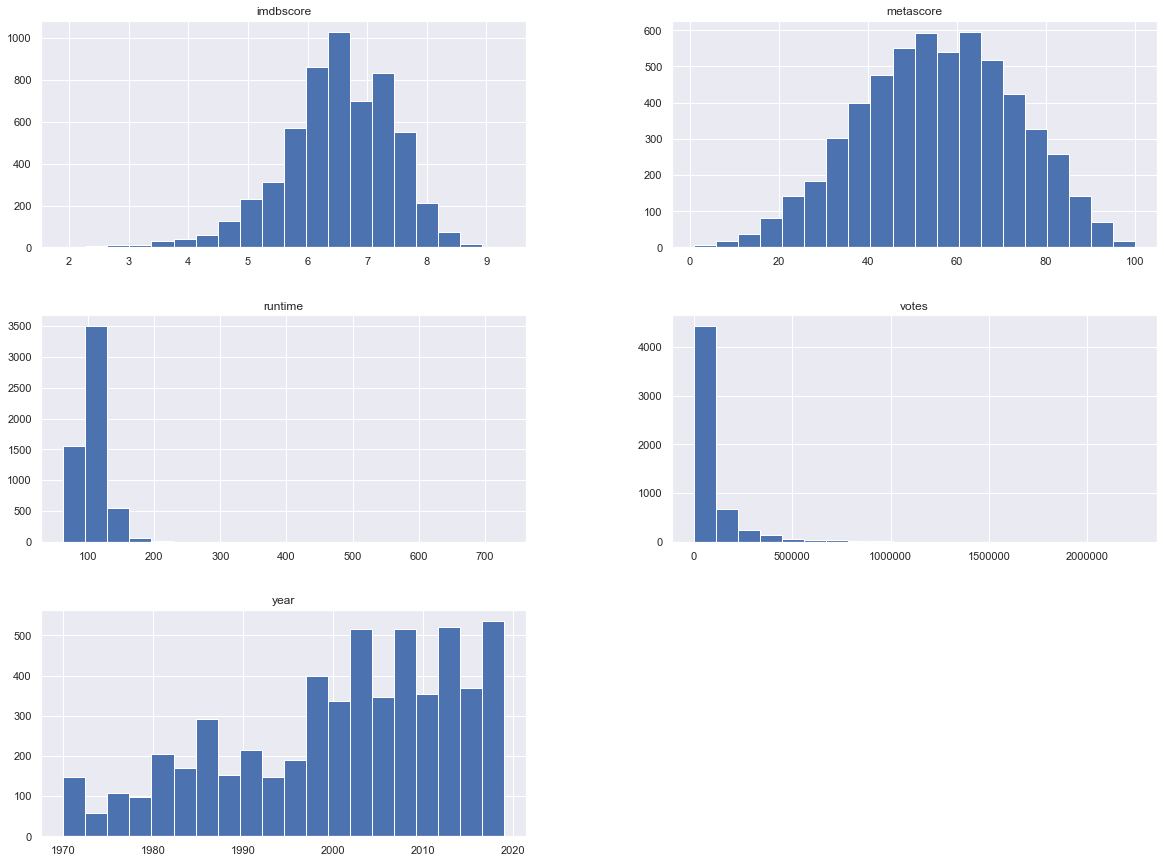

In [7]:
imdb.hist(bins=20, figsize=(20,15))
plt.show()

Bias in our data set. 
* The IMDB scores are centered aroung 5-8 with low frequency below or above this number.
* Number of votes and run time are right skewed. They will need to be normalized

## Data Cleaning 
### Genre

Based on previous imdb analysis, I would guess that genre plays a role in prediciting user scores. Since IMBD codes up to three genres per movie, they need to be parsed. One way to do this is to create a boolean field for each movie category. But first, let's clean the string to list values and look at which genres are represented.

In [8]:
# convert string of multiple genres to array
def cleanGenre(old_genres):
    old_genres = np.array(old_genres)
    all_genres = []
    idx_genres = []
    for i in range(0, len(old_genres)):
        g = old_genres[i]
        g = g[1:-1]
        g = g.strip()
        g = g.split(", ")
        for j in range(0, len(g)):
            all_genres.append(g[j][1:-1])
            idx_genres.append(i)
    all_genres=np.array(all_genres)[np.newaxis]
    idx_genres=np.array(idx_genres)[np.newaxis]

    return all_genres, idx_genres

In [9]:
# custom one hot encoder for each genre (boolean field)
def encodeGenre(all_genres, idx_genres, genres_to_encode):
    num_data = len(np.unique(idx_genres))
    genres_encoded = np.zeros((num_data, len(genres_to_encode)))
    for g in range(0, len(genres_to_encode)):
        genres_encoded[[idx_genres[all_genres == genres_to_encode[g]]], g] = 1
    return genres_encoded
    

In [10]:
# clean and endode genres
all_genres, idx_genres = cleanGenre(imdb["genre"])
genres_to_encode = np.unique(all_genres)
genres_encoded = encodeGenre(all_genres, idx_genres, genres_to_encode)

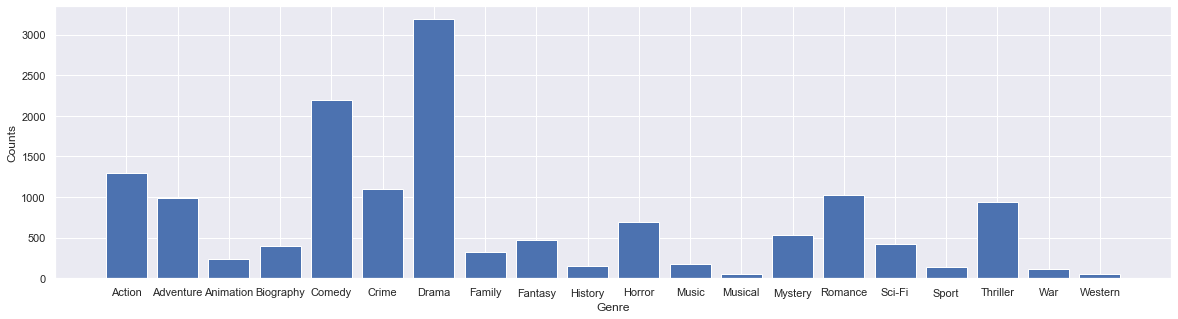

In [11]:
# Plot frequency of each genre
plt.figure(figsize=(20,5))
plt.bar(genres_to_encode, np.sum(genres_encoded, 0))
plt.ylabel("Counts")
plt.xlabel("Genre")
plt.show()

Some of the genres have very low counts. For example. war, music, musical, and western. Do these and other genres overlap with another genre? If there is a strong correlation, categories can be removed or merged for future to limit the number of parameters.

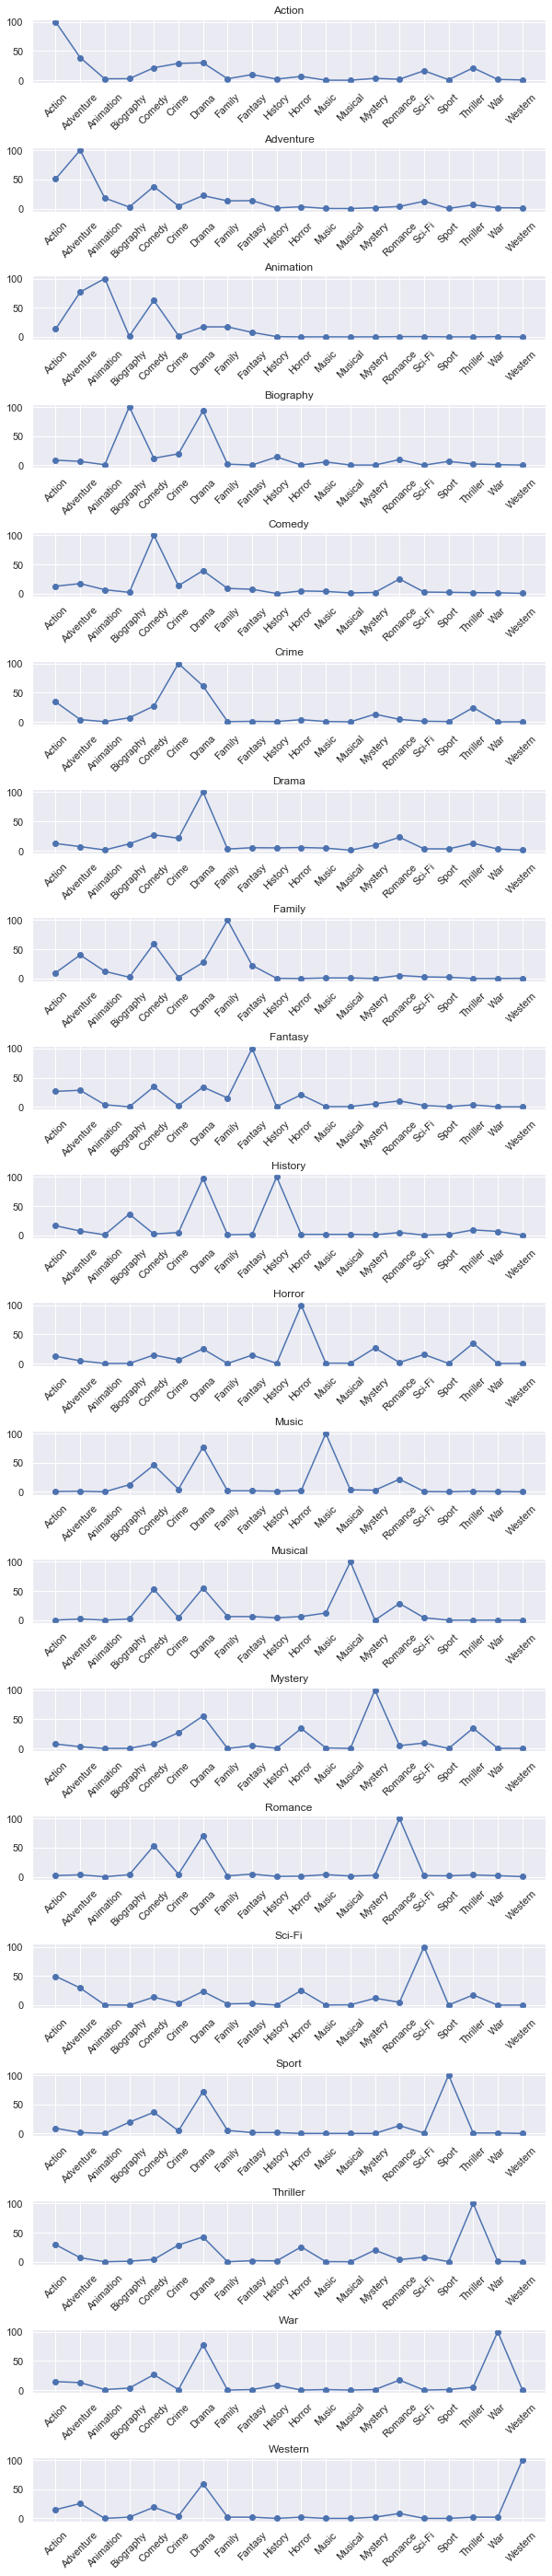

In [12]:
# Plot overlap of each genre as subplot for visualization
fig, axes = plt.subplots(len(genres_to_encode), 1, figsize=(10,50))
fig.subplots_adjust(hspace=1)

for i in range(0, len(genres_to_encode)):
    idx = genres_encoded[:,i] == 1
    genre_overap = np.sum(genres_encoded[idx,:],0)
    genre_overap = genre_overap/ genre_overap[i]*100
    axes[i].plot(genres_to_encode, genre_overap, '-o')
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
    axes[i].set_title(genres_to_encode[i])


In [13]:
def plotGenreScores(genres_encoded, scores, genres_to_encode):
    fig, ax = plt.subplots(figsize=(20,5))
    for i in range(0,len(genres_to_encode)):
        idx = np.where(genres_encoded[:,i] == 1)
        ax.violinplot(dataset=scores[idx], positions=[i])
        ax.plot([i],np.mean(scores),'ko')

    plt.ylabel("Average IMDB Score")
    plt.xlabel("Average IMDB Score")
    plt.xticks(np.arange(len(genres_to_encode)), genres_to_encode,rotation='45')
    plt.show()

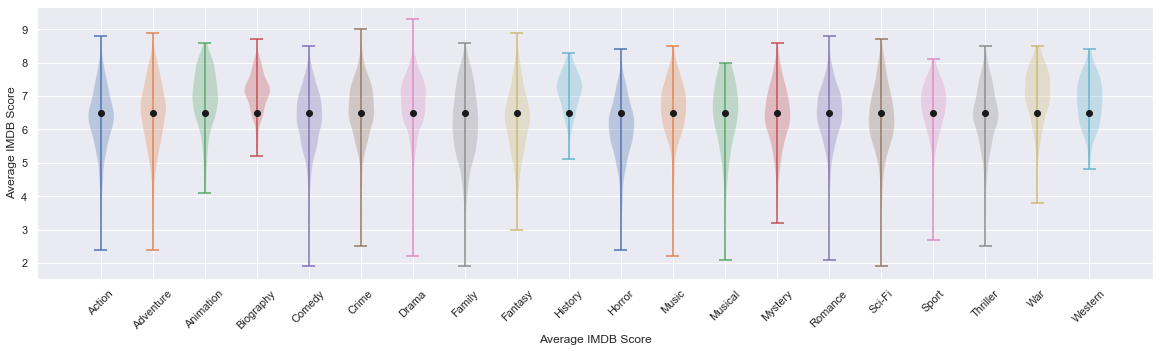

In [14]:
plotGenreScores(genres_encoded, imdb["imdbscore"].values, genres_to_encode)

Certain genres are higher rated than others, on average. For example, top ratings including anything "historical" as history, biography, and war films are the highest rated. As expected, horror movies are the lowest rated (even if they are my favorite!)

In [15]:
def plotGenreYear(genres_encoded, years, scores, unique_genres, genres_to_plot):
    years_int = [int(i) for i in years] 
    sns.set(rc={'figure.figsize':(12,6)})
    for i in range(0,len(genres_to_plot)):
        p = np.where((genres_to_plot[i] == unique_genres)==1)
        idx = np.where(genres_encoded[:,p] == 1)[0]
        sns.lineplot(years[idx], scores[idx])
    plt.legend(genres_to_plot)
    plt.xlabel("Years")
    plt.ylabel("IMDB Score")
    plt.show()

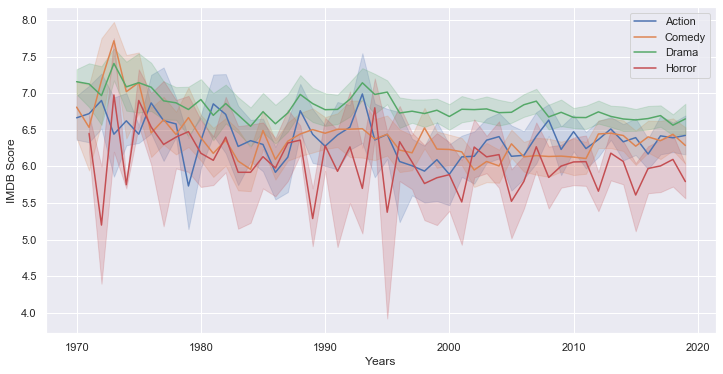

In [16]:
years =  imdb["year"].values
scores = imdb["imdbscore"].values
unique_genres = np.unique(all_genres)
genres_to_plot =  ["Action", "Comedy", "Drama", "Horror"]
plotGenreYear(genres_encoded, years, scores, unique_genres, ["Action", "Comedy", "Drama", "Horror"])

In [17]:
years_int = [int(i) for i in years] 

### Function for preparing Genre from start to finish

In [18]:
def prepareGenre(imdb, genres_to_encode=[], make_sparse=True):
    all_genres, idx_genres = cleanGenre(imdb["genre"])
    if not genres_to_encode:
        genres_to_encode = np.unique(all_genres)
    genres_encoded = encodeGenre(all_genres, idx_genres, genres_to_encode)

    if make_sparse: 
        genres_encoded = sp.sparse.csr_matrix(genres_encoded)
    
    return genres_encoded

In [19]:
genres_to_encode = [["Animation"], ["Adventure"], ["Comedy"], ["Drama"], ["Romance"],
                    ["Biography"],["Action"], ["Thriller"], ["Crime"], ["Horror"]]
genres_encoded = prepareGenre(imdb, genres_to_encode, make_sparse=True)
genres_encoded

<5680x10 sparse matrix of type '<class 'numpy.float64'>'
	with 12039 stored elements in Compressed Sparse Row format>

## Data Cleaning 
### Year

Year is not technically not continuous and therefore will need to be encoded. Howerever, let's first see if there is a correlation between imdb rating and year.

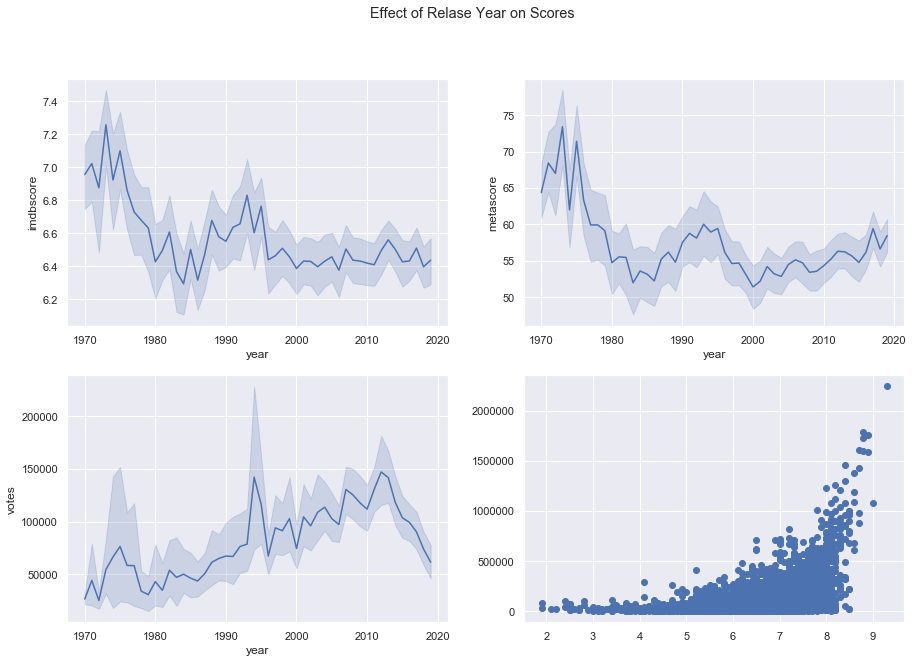

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Effect of Relase Year on Scores')
sns.lineplot(imdb["year"], imdb["imdbscore"], ax=axes[0, 0])
sns.lineplot(imdb["year"], imdb["metascore"], ax=axes[0, 1])
sns.lineplot(imdb["year"], imdb["votes"], ax=axes[1, 0])
ax1 = axes[1,1]
ax1.scatter(imdb["imdbscore"], imdb["votes"])
plt.show()

Release years shows the same effect on IMDB and Metacritic scores. There is a bias with low ratings and low votes and higher ratings with high votes. However, the number of votes across years is mostly consistent, with the most reviews occuring between 1990 and 2010. This is likely due to IMDB launching in 1990. OneHotEncoder of year will generate 50 new features inthis data alone which is absurd. Let's first try without encoding the data. If not, the years can be binned into decades to reduce the number of features

### Prepare Year feature via one hot encoder
#### split into decades

In [21]:
def prepareYear(imdb, decades=[1970,1980,1990,2000,2010], make_sparse=True):
    years = imdb["year"].values
    if not decades:
        decades = np.unique(years)
    years_encoded = np.zeros((len(years),len(decades)))

    for d in range(0, len(decades)):
        idx1 = years >= decades[d]
        idx2 = years < decades[d] + 10
        idx3 = np.intersect1d(np.where(idx1==1), np.where(idx2==1))
        years_encoded[idx3,d] = 1
        
    if make_sparse: 
        years_encoded = sp.sparse.csr_matrix(years_encoded)
    
    return years_encoded

In [22]:
years_encoded = prepareYear(imdb)
years_encoded

<5680x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5680 stored elements in Compressed Sparse Row format>

## Data Cleaning 
### Rating

In [23]:
imdb["rating"].value_counts()

R            2718
PG-13        1494
PG            899
Not Rated     250
G             130
Unrated        80
TV-MA          44
GP             18
NC-17          16
TV-14          10
M              10
TV-PG           5
Approved        4
Passed          1
X               1
Name: rating, dtype: int64

Typical movie genres are: G, PG, PG-13, R, NC-17, Unrated. 
* Data set includes TV movies; these ratings can be converted over to movie ratings
* X is the old NC-17
* Let's go ahead and assume Passed, Approved, and GP are PG
* "Unrated" is the term I added to when scraping if there was no rating value. Let's merge this w/ Not Rated

In [24]:
def cleanRating(df):
    imdb = df.replace("Unrated", "Not Rated")
    df = df.replace("TV-MA", "R")
    df = df.replace("GP", "PG")
    df = df.replace("TV-14", "PG-13")
    df = df.replace("TV-PG", "PG")
    df = df.replace("M", "R")
    df = df.replace("Approved", "PG")
    df = df.replace("TV-G", "G")
    df = df.replace("X", "NC-17")
    df = df.replace("Passed", "PG")
    
    # to reduce features, lets also group NC17 w/ R and G w/ PG
    df = df.replace("G", "PG")
    df = df.replace("NC-17", "R")
    
    return df

In [25]:
imdb = cleanRating(imdb)
imdb["rating"].value_counts()

R            2789
PG-13        1504
PG           1057
Not Rated     250
Unrated        80
Name: rating, dtype: int64

now these values need to be encoded. Should be able to use scikitlearn for this. Start to finish data clean & prep function

In [26]:
def prepareRating(imdb, ratings=['Not Rated', 'PG', 'PG-13', 'R']): 
    rating_values = imdb["rating"].values
    rating_encoded = np.zeros((len(rating_values), len(ratings)))
    for i in range(0, len(ratings)):
        idx = rating_values == ratings[i]
        rating_encoded[np.where(idx==1), i] = 1
    
    return rating_encoded

In [27]:
ratings_encoded = prepareRating(imdb)
ratings_encoded

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

### Data Cleaning 
### Runtime & Number of Reviews

Both runtime and number of reviews are continuous variables that do not need to be encoded since the magnitude is likely to matter. They do, however, need to be scaled. Let's perform standardization

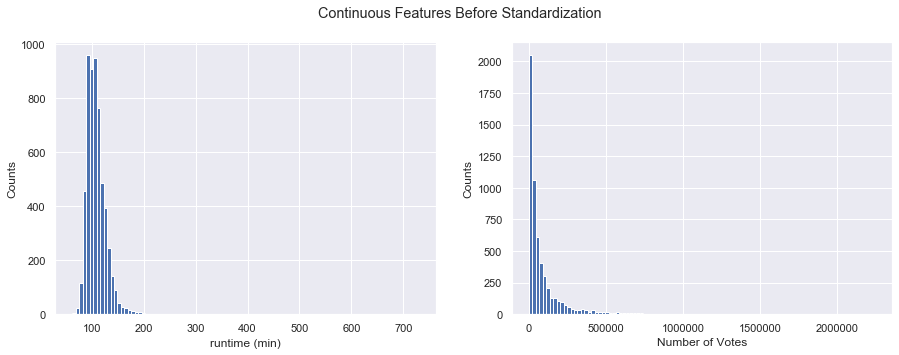

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Continuous Features Before Standardization')
ax1.hist(imdb["runtime"].values, bins=100)
ax1.set_xlabel('runtime (min)')
ax1.set_ylabel('Counts')

ax2.hist(imdb["votes"].values, bins=100)
ax2.set_xlabel('Number of Votes')
ax2.set_ylabel('Counts')

plt.show()

a lot of data have low counts for number of votes. let's take a closer look. 

In [29]:
imdb[['votes']].describe()

,votes
count,5.680000e+03
mean,9.189567e+04
std,1.555653e+05
min,2.050000e+02
25%,1.467975e+04
50%,3.841800e+04
75%,9.866500e+04
max,2.243460e+06


All the data have at least 40 votes but there is a very large range in the number of votes. This leads to skewed distribution that may be difficult to train as a feature. 

In [30]:
def standardizeField(df_field, df_field_train=[], make_sparse=True):
    values = np.array([df_field.values]).T
    
    if len(df_field_train) == 0:
        values_standardized = (values-np.mean(values)) / np.std(values)
    else:
        values_train = np.array([df_field_train.values]).T
        values_standardized = (values-np.mean(values_train)) / np.std(values_train)   
     
    if make_sparse: 
        values_standardized = sp.sparse.csr_matrix(values_standardized)
    
    return values_standardized

In [31]:
runtime_standardized = standardizeField(imdb["runtime"])
runtime_standardized

<5680x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5680 stored elements in Compressed Sparse Row format>

In [32]:
votes_standardized = standardizeField(imdb["votes"])
votes_standardized

<5680x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5680 stored elements in Compressed Sparse Row format>

### Data Cleaning
### Metacritic score

Metacritic score is an aggregated score of critics feedback (not user scores). This feature is continuous and will need to be standardized. First, let's examine the relationship between critics and user ratings. This is likely highly correlated and will make for a good predictor. 

In [33]:
imdb['metascore'].describe()

count    5680.000000
mean       55.794894
std        17.730605
min         1.000000
25%        43.000000
50%        56.000000
75%        69.000000
max       100.000000
Name: metascore, dtype: float64

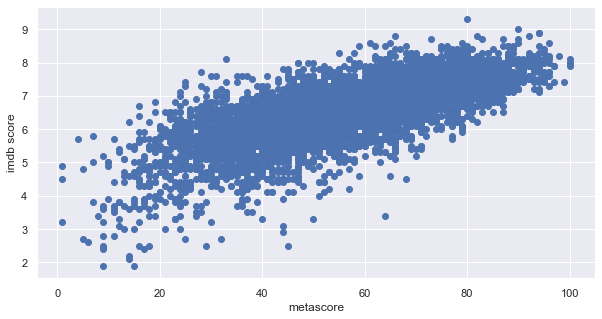

In [34]:
plt.figure(figsize=(10,5))
plt.scatter(imdb['metascore'].values, imdb['imdbscore'].values)
plt.xlabel("metascore")
plt.ylabel("imdb score")
plt.show()

In [35]:
# standardize metacritic score
metacritic_standardized = standardizeField(imdb["metascore"])
metacritic_standardized

<5680x1 sparse matrix of type '<class 'numpy.float64'>'
	with 5680 stored elements in Compressed Sparse Row format>

# Model Training 

### Merge Features into single Sparse Vector 
[year, rating, runtime, genres]

In [36]:
def prepareIMDB(df, genres_to_encode, years_to_encode, years=True,
                ratings=True, runtimes=True, votes=True, genres=True, metascore=True):
    
    # can chose to include or not include specific features
    
    from scipy import sparse
    
    features_created = 0
    
    if years:
        years_encoded = prepareYear(df, years_to_encode)
        features = years_encoded
        features_created = 1
                
    if ratings: 
        ratings_encoded = prepareRating(df)
        if not features_created:
            features = ratings_encoded
            features_created = 1
        else: features = sparse.hstack((features, ratings_encoded))
    
    if runtimes:
        runtime_std = standardizeField(df["runtime"])
        if not features_created:
            features = runtime_std
            features_created = 1
        else: features = sparse.hstack((features, runtime_std))
            
    if votes:
        votes_std = standardizeField(df["votes"])
        if not features_created:
            features = votes_std
            features_created = 1
        else: features = sparse.hstack((features, votes_std))
    
    if genres:
        genres_encoded = prepareGenre(df, genres_to_encode)
        if not features_created:
            features = genres_encoded
            features_created = 1
        else: features = sparse.hstack((features, genres_encoded))
        
    if metascore:
        metacritic_standardized = standardizeField(df["metascore"])
        if not features_created:
            features = metacritic_standardized
            features_created = 1
        else: features = sparse.hstack((features, metacritic_standardized))
    
    return features

### Features

In [37]:
years_to_encode = [1970, 1980, 1990, 2000, 2010]
genres_to_encode = [["Animation"], ["Adventure"], ["Comedy"], ["Drama"], ["Romance"],
                    ["Biography"],["Action"], ["Thriller"], ["Crime"], ["Horror"]]
features = prepareIMDB(imdb, genres_to_encode, years_to_encode)
features

<5680x22 sparse matrix of type '<class 'numpy.float64'>'
	with 40359 stored elements in COOrdinate format>

### Labels

In [38]:
labels = imdb["imdbscore"].values
labels

array([7. , 6.5, 7.2, ..., 6.1, 6.6, 5.6])

### Model 1: Linear Regression (w/ cross validation)

In [39]:
def printScores(scores): 
    print("Scores", scores)
    print("mean:", np.mean(scores))
    print("std:", np.std(scores))

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, features, labels, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-scores)
printScores(lin_reg_rmse_scores)

Scores [0.59490645 0.61829687 0.61444788 0.60140273 0.55455735 0.55977418
 0.55045575 0.57637492 0.55832047 0.57744905]
mean: 0.5805985655985066
std: 0.023976923019758224


Typical IMDB scores range from 0 to 10 and on a first pass my model is off ±0.73 which is not great but not horrible either. Let's try a more complicated model before moving on to feature eingineering

### Model 2: Decision Tree (w/ cross validation)

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, features, labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
printScores(tree_rmse_scores)

Scores [0.82519737 0.79004591 0.8200395  0.76396621 0.73543367 0.79748725
 0.76454212 0.80704425 0.75098527 0.72981041]
mean: 0.7784551956911957
std: 0.032562635071362624


Decision tree peforms worse than linear regression model

### Model 3: Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100)

forest_model = forest_reg.fit(features, labels)
predictions_forest = forest_reg.predict(features)
forest_rmse = mean_squared_error(predictions_forest, labels)
forest_rmse = np.sqrt(forest_rmse)

printScores(forest_rmse)

Scores 0.20810135920801986
mean: 0.20810135920801986
std: 0.0


In [43]:
sample = imdb[0:10]
sample_features = prepareIMDB(sample, genres_to_encode, years_to_encode)
predictions_sample = forest_reg.predict(sample_features)

print("Predicted Scores: ", predictions_forest)
print("True Scores     :", sample["imdbscore"].values)

Predicted Scores:  [7.037 6.58  7.071 ... 6.139 6.438 5.67 ]
True Scores     : [7.  6.5 7.2 7.1 5.9 5.  6.  5.9 6.8 6.4]


**Random forest is doing the best so far with an error of ± 0.213 !!**

### Model 4: SVM

In [44]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(features, labels)
predictions_svm = svm_reg.predict(features)
svm_rmse = mean_squared_error(predictions_svm, labels)
svm_rmse = np.sqrt(svm_rmse)

printScores(svm_rmse)

Scores 0.5816860816346016
mean: 0.5816860816346016
std: 0.0


SVM is returning the same error as linear regression alone. Of the four models tested, **Random Forest is performing best performing model**

## Exploring the Feature Space

In [45]:
def runRandomForest(features, labels, print_rmse=True):
    forest_reg = RandomForestRegressor(n_estimators=100)
    forest_model = forest_reg.fit(features, labels)
    predictions_forest = forest_reg.predict(features)
    forest_rmse = mean_squared_error(predictions_forest, labels)
    forest_rmse = np.sqrt(forest_rmse)
    if print_rmse:
        printScores(forest_rmse)
    
    return forest_rmse

In [46]:
# remove each feature and check score
features_no_year = prepareIMDB(imdb, genres_to_encode, years_to_encode, years=False)
features_no_ratings = prepareIMDB(imdb, genres_to_encode, years_to_encode, ratings=False)
features_no_runtime = prepareIMDB(imdb, genres_to_encode, years_to_encode, runtimes=False)
features_no_votes = prepareIMDB(imdb, genres_to_encode, years_to_encode, votes=False)
features_no_gerne = prepareIMDB(imdb, genres_to_encode, years_to_encode, genres=False)
features_no_metascore = prepareIMDB(imdb,genres_to_encode, years_to_encode, metascore=False)

In [47]:
rmse_no_year = runRandomForest(features_no_year, labels)

Scores 0.21158415608365802
mean: 0.21158415608365802
std: 0.0


In [48]:
rmse_no_ratings = runRandomForest(features_no_ratings, labels)

Scores 0.20925886110438477
mean: 0.20925886110438477
std: 0.0


In [49]:
rmse_no_runtime = runRandomForest(features_no_runtime, labels)

Scores 0.2095350520275044
mean: 0.2095350520275044
std: 0.0


In [50]:
rmse_no_votes = runRandomForest(features_no_votes, labels)

Scores 0.23317698642132276
mean: 0.23317698642132276
std: 0.0


In [51]:
rmse_no_genre = runRandomForest(features_no_gerne, labels)

Scores 0.21621487747016063
mean: 0.21621487747016063
std: 0.0


In [52]:
rmse_no_metascore = runRandomForest(features_no_metascore, labels)

Scores 0.25914528458207897
mean: 0.25914528458207897
std: 0.0


Metascore is the strongest predictor of imdb user scores, which makes sense. Number of votes is the second best, with gerne in third. Year, ratings, and runtime seem to be weak predictors. What if we remove them?

In [53]:
features_temp =  prepareIMDB(imdb,genres_to_encode,[], years=False, runtimes=False, ratings=False)
rmse_temp = runRandomForest(features_temp, labels, print_rmse=False)

In [54]:
print('RMSE with all features:', "%.3f" % forest_rmse)
print('RMSE without year, runtimes, rating:',"%.3f" % rmse_temp)
print('RMSE Difference:', "%.3f" % (forest_rmse-rmse_temp))

RMSE with all features: 0.208
RMSE without year, runtimes, rating: 0.224
RMSE Difference: -0.016


Additon of 3 extra features accounts for a total of 0.017 improvemnt in imdb score prediction.

In [55]:
features_all_gerne = prepareIMDB(imdb,[], years_to_encode, genres=True)
rmse_all_genres = runRandomForest(features_all_gerne, labels)

Scores 0.20393466357400408
mean: 0.20393466357400408
std: 0.0


In [56]:
print('RMSE with 10 Gernes: ', "%.3f" % forest_rmse)
print('RMSE with 20 Genres', "%.3f" % rmse_all_genres)
print('RMSE Difference:', "%.3f" % (forest_rmse-rmse_all_genres))

RMSE with 10 Gernes:  0.208
RMSE with 20 Genres 0.204
RMSE Difference: 0.004


My hypothesis was correct: reducing genres had litle effect on the prediction accuracy with random forest model and trains much faster. 

In [57]:
years_to_encode = []
features_all_years = prepareIMDB(imdb,genres_to_encode, years_to_encode)
rmse_all_years = runRandomForest(features_all_years, labels)

Scores 0.20233103540318256
mean: 0.20233103540318256
std: 0.0


In [58]:
print('RMSE with 10 Gernes: ', "%.3f" % forest_rmse)
print('RMSE with 20 Genres', "%.3f" % rmse_all_years)
print('RMSE Difference:', "%.3f" % (forest_rmse-rmse_all_years))

RMSE with 10 Gernes:  0.208
RMSE with 20 Genres 0.202
RMSE Difference: 0.006


Encoding each year seperately takes much longer to train and model and shows little improvement in accuracy than encoding by decades. Overall, year is surprisingly not an effective predictor of imdb scores

How accurate is imdb score prediction using only metascore? 

In [59]:
features_meta_only = prepareIMDB(imdb, [], [], years=False, ratings=False, runtimes=False,votes=False, genres=False)
rmse_meta_only = runRandomForest(features_meta_only, labels, print_rmse=False)
print('RMSE with all features: ', "%.3f" % forest_rmse)
print('RMSE only metascore', "%.3f" % rmse_meta_only)
print('RMSE Difference:', "%.3f" % (forest_rmse-rmse_meta_only))

RMSE with all features:  0.208
RMSE only metascore 0.639
RMSE Difference: -0.431


Including the other features than just metascore is clearly important for predicting imdb user scores

## Best Fit Model: Random Forest

Overall, random forest performs better than other models with a rmse 0f 0.213 (2.13% prediciton error). 

## Test Random Forest on Training Set
Check for overfitting 

In [60]:
# similar function to prepare IMDB but re-wrote to use mean values of training data for standardization 
def transformIMDB(df_test, df_train, genres_to_encode, years_to_encode, years=True,
                ratings=True, runtimes=True, votes=True, genres=True, metascore=True):
    
    from scipy import sparse
    
    features_created = 0
    
    if years:
        years_encoded = prepareYear(df_test, years_to_encode)
        features = years_encoded
        features_created = 1
                
    if ratings: 
        ratings_encoded = prepareRating(df_test)
        if not features_created:
            features = ratings_encoded
            features_created = 1
        else: features = sparse.hstack((features, ratings_encoded))
    
    if runtimes:
        runtime_std = standardizeField(df_test["runtime"], df_train["runtime"])
        if not features_created:
            features = runtime_std
            features_created = 1
        else: features = sparse.hstack((features, runtime_std))
            
    if votes:
        votes_std = standardizeField(df_test["votes"],df_train["votes"])
        if not features_created:
            features = votes_std
            features_created = 1
        else: features = sparse.hstack((features, votes_std))
    
    if genres:
        genres_encoded = prepareGenre(df_test, genres_to_encode)
        if not features_created:
            features = genres_encoded
            features_created = 1
        else: features = sparse.hstack((features, genres_encoded))
        
    if metascore:
        metacritic_standardized = standardizeField(df_test["metascore"], df_train["metascore"])
        if not features_created:
            features = metacritic_standardized
            features_created = 1
        else: features = sparse.hstack((features, metacritic_standardized))
    
    return features


In [61]:
years_to_encode = [1970, 1980, 1990, 2000, 2010]
genres_to_encode = [["Animation"], ["Adventure"], ["Comedy"], ["Drama"], ["Romance"],
                    ["Biography"],["Action"], ["Thriller"], ["Crime"], ["Horror"]]

features_test = transformIMDB(imdb_test, imdb, genres_to_encode, years_to_encode)

labels_test = imdb_test["imdbscore"]
forest_model_test = forest_reg.fit(features_test, labels_test)
predictions_forest_test = forest_reg.predict(features_test)
forest_rmse_test = mean_squared_error(predictions_forest_test, labels_test)
forest_rmse_test = np.sqrt(forest_rmse_test)

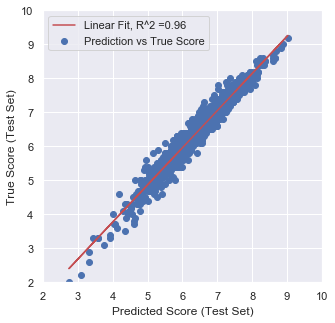

In [62]:
# Plot predicted vs true on test data 
from sklearn import metrics
plt.figure(figsize=(5,5))
plt.scatter(predictions_forest_test, labels_test)
m, b = np.polyfit(predictions_forest_test, labels_test, 1)
labels_pred = m*predictions_forest_test + b
r2 = metrics.r2_score(labels_test, labels_pred)
plt.plot(predictions_forest_test, labels_pred, '-r')
plt.xlim((2, 10)) 
plt.ylim((2, 10)) 
plt.xlabel("Predicted Score (Test Set)")
plt.ylabel("True Score (Test Set)")
plt.legend(('Linear Fit, R^2 =' "%.2f" %  r2, 'Prediction vs True Score'))

plt.savefig('prediction_result.png')
plt.show()

In [63]:
print('RMSE on Train Set: ', "%.3f" % forest_rmse)
print('RMSE on Test Set', "%.3f" % forest_rmse_test)
print('R^2:', "%.2f" %  r2)

RMSE on Train Set:  0.208
RMSE on Test Set 0.217
R^2: 0.96


The RMSE on the test set is actually improved vs the training set. This sugggests our model is not overfit and performs well on new data.